# Prediction by Ichimoku Cloud

In [1]:
import pandas as pd
df = pd.read_csv('BTC_data_with_ichimoku.csv')
df.sort_index(ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)

In [2]:
df

,Date,Close,Open,High,Low,Vol,Change,ich_base_line,ich_conv_line,ich_span_a,ich_span_b
0,2023-08-17,28576.7,28726.1,28771.8,28381.0,53520.0,-0.52,29359.00,29242.50,30652.475,28301.25
1,2023-08-16,28726.3,29195.3,29251.1,28717.6,43710.0,-1.61,29474.00,29443.10,30692.950,28301.25
2,2023-08-15,29195.3,29426.7,29472.0,29118.6,33810.0,-0.79,29474.00,29444.80,30692.950,28301.25
3,2023-08-14,29426.7,29300.1,29689.0,29116.0,39300.0,0.43,29509.50,29444.80,30694.550,28301.25
4,2023-08-13,29300.1,29428.2,29468.5,29272.3,13490.0,-0.44,29509.50,29444.80,30694.550,28301.25
...,...,...,...,...,...,...,...,...,...,...,...
1769,2018-10-13,6321.7,6291.3,6329.3,6282.8,94450.0,0.48,6405.15,6452.85,NaN,6541.60
1770,2018-10-12,6291.3,6239.2,6344.8,6206.8,147400.0,0.84,6405.15,6452.85,NaN,6602.55
1771,2018-10-11,6239.1,6618.0,6622.5,6206.2,245280.0,-5.72,6405.15,6452.85,NaN,6602.55
1772,2018-10-10,6618.0,6650.6,6653.5,6526.0,101930.0,-0.49,6405.15,6367.20,NaN,6602.55


In [3]:
df.rename(columns={
    'ich_base_line': 'BaseLine',
    'ich_conv_line': 'ConvLine',
    'ich_span_a': 'SpanA',
    'ich_span_b': 'SpanB'
}, inplace=True)

Let's save the df in two types:

In [4]:
df.Date = pd.to_datetime(df.Date)

dfTS = df.set_index(df.Date)
dfTS.drop(['Date'], axis=1, inplace=True)

## Is Ichmoku Indicator Data Accurate?

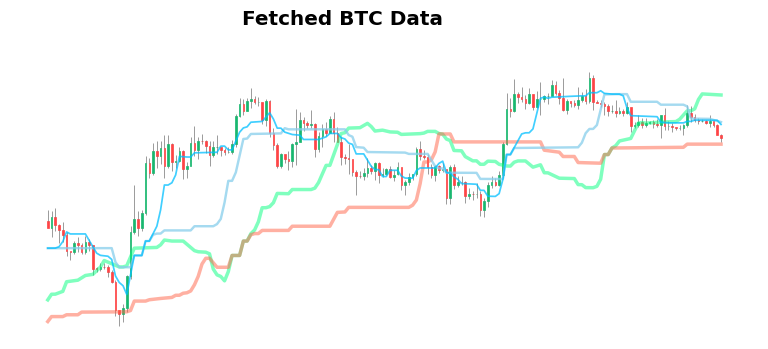

In [5]:
import mplfinance as mpf
import matplotlib.pyplot as plt

df_90_days = dfTS.iloc[:180, :].sort_index(ascending=True)

def ichimoku_btc_chart_60days(fs1, fs2):
    cloud_color = mpf.make_marketcolors(up='g', down='r', inherit=True)

    # Ichimoku data
    ichimoku = [
        mpf.make_addplot(df_90_days['SpanA'], color='springgreen',width=2.5, alpha=0.5),
        mpf.make_addplot(df_90_days['SpanB'], color='tomato',width=2.5, alpha=0.5),
        mpf.make_addplot(df_90_days['BaseLine'], color='skyblue', width=1.75, alpha=0.75),
        mpf.make_addplot(df_90_days['ConvLine'], color='deepskyblue', width=1.25, alpha=0.75)
    ]

    # Draw the graph
    mpf.plot(
        df_90_days, 
        type='candle', 
        addplot=ichimoku, 
        style='yahoo', 
        figsize = (fs1,fs2),
        title = 'Fetched BTC Data',
        axisoff=True
    )



ichimoku_btc_chart_60days(10.4,4)

**_TradingView Data_**

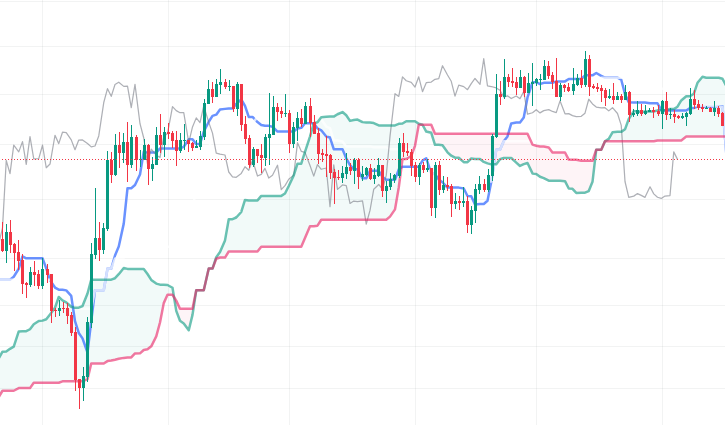

## Make the dataset with Ichimoku signals that'll be put into model

In [6]:
# Price/Cloud Position
for i in range(len(df)):
    
    if ((df.loc[i, 'Close'] < df.loc[i, 'SpanA']) & (df.loc[i, 'Close'] < df.loc[i, 'SpanB'])): df.loc[i, 'PriceUnderCloud'] = 1
    else: df.loc[i, 'PriceUnderCloud'] = 0

    if (((df.loc[i, 'Close']>= df.loc[i, 'SpanA']) & (df.loc[i, 'Close'] <= df.loc[i, 'SpanB'])) | ((df.loc[i, 'Close'] <= df.loc[i, 'SpanA']) & (df.loc[i, 'Close'] >= df.loc[i, 'SpanB']))): df.loc[i, 'PriceInCloud'] = 1
    else: df.loc[i, 'PriceInCloud'] = 0
    
    if ((df.loc[i, 'Close'] > df.loc[i, 'SpanA']) & (df.loc[i, 'Close'] > df.loc[i, 'SpanB'])): df.loc[i, 'PriceOverCloud'] = 1
    else: df.loc[i, 'PriceOverCloud'] = 0

# Price/Cloud Intersect
for i in range(len(df) - 1):
               
    if ((df.loc[i, 'PriceUnderCloud'] == 1) & ((df.loc[i+1, 'PriceOverCloud'] == 1) | (df.loc[i+1, 'PriceInCloud'] == 1))): df.loc[i, 'PriceCloudIntersectBear'] = 1
    else: df.loc[i, 'PriceCloudIntersectBear'] = 0

    if ((df.loc[i, 'PriceOverCloud'] == 1) & ((df.loc[i+1, 'PriceUnderCloud'] == 1) | (df.loc[i+1, 'PriceInCloud'] == 1))): 
        df.loc[i, 'PriceCloudIntersectBull'] = 1
    else: df.loc[i, 'PriceCloudIntersectBull'] = 0

In [7]:
for i in range(len(df)):

    # Price/BaseLine and Price/ConvLine Position (Under or Over)
    if df.loc[i,'Close'] >= df.loc[i, 'BaseLine']: df.loc[i, 'PriceBaseLinePosition'] = 1
    else: df.loc[i, 'PriceBaseLinePosition'] = 0

    if df.loc[i,'Close'] >= df.loc[i, 'ConvLine']: df.loc[i, 'PriceConvLinePosition'] = 1
    else: df.loc[i, 'PriceConvLinePosition'] = 0

    # Price/BaseLine and Price/ConvLine Distance
    df.loc[i, 'PriceBaseLineDistance'] = df.loc[i, 'Close'] - df.loc[i, 'BaseLine']
    df.loc[i, 'PriceConvLineDistance'] = df.loc[i, 'Close'] - df.loc[i, 'ConvLine']

    # ConvLine/BaseLine Position

    if df.loc[i, 'ConvLine'] >= df.loc[i, 'BaseLine']: df.loc[i, 'ConvLineBaseLinePosition'] = 1
    else: df.loc[i, 'ConvLineBaseLinePosition'] = 0

 
# ConvLine/BaseLine Inersect
for i in range(len(df)-1):
    if ((df.loc[i, 'ConvLineBaseLinePosition'] == 1) & (df.loc[i+1, 'ConvLineBaseLinePosition'] == 0)): df.loc[i, 'ConvBaseIntersectBull'] = 1
    else: df.loc[i, 'ConvBaseIntersectBull'] = 0

    if ((df.loc[i, 'ConvLineBaseLinePosition'] == 0) & (df.loc[i+1, 'ConvLineBaseLinePosition'] == 1)): df.loc[i, 'ConvBaseIntersectBear'] = 1
    else: df.loc[i, 'ConvBaseIntersectBear'] = 0

In [8]:
# Forward Cloud Width (Scaler)
break_check = False

for i in range(len(df)):
    # span A
    spanA = (df.loc[i, 'ConvLine'] + df.loc[i, 'BaseLine']) / 2

    sum_price_last_52_days = 0
    if i + 52 <= len(df):
        for j in range(52):
                sum_price_last_52_days += df.loc[i+j, 'Close']
                spanB = sum_price_last_52_days / 52 
                cloud_width = spanA - spanB
                df.loc[i, 'ForwardCloudWidth'] = cloud_width
    else: break
            


# Forward Cloud Intersect (Encder)

for i in range(len(df)-52):
    if ((df.loc[i, 'ForwardCloudWidth'] <= 0) & (df.loc[i+1, 'ForwardCloudWidth'] > 0)): df.loc[i, 'ForwardCloudIntersectBear'] = 1
    else: df.loc[i, 'ForwardCloudIntersectBear'] = 0
    
    if ((df.loc[i, 'ForwardCloudWidth'] >= 0) & (df.loc[i+1, 'ForwardCloudWidth'] < 0)): df.loc[i, 'ForwardCloudIntersectBull'] = 1
    else: df.loc[i, 'ForwardCloudIntersectBull'] = 0

In [9]:
df.dropna(axis = 0, inplace=True)

df.iloc[:,:]

,Date,Close,Open,High,Low,Vol,Change,BaseLine,ConvLine,SpanA,...,PriceBaseLinePosition,PriceConvLinePosition,PriceBaseLineDistance,PriceConvLineDistance,ConvLineBaseLinePosition,ConvBaseIntersectBull,ConvBaseIntersectBear,ForwardCloudWidth,ForwardCloudIntersectBear,ForwardCloudIntersectBull
0,2023-08-17,28576.7,28726.1,28771.8,28381.0,53520.0,-0.52,29359.00,29242.50,30652.475,...,0.0,0.0,-782.30,-665.80,0.0,0.0,0.0,-523.228846,0.0,0.0
1,2023-08-16,28726.3,29195.3,29251.1,28717.6,43710.0,-1.61,29474.00,29443.10,30692.950,...,0.0,0.0,-747.70,-716.80,0.0,0.0,0.0,-397.934615,0.0,0.0
2,2023-08-15,29195.3,29426.7,29472.0,29118.6,33810.0,-0.79,29474.00,29444.80,30692.950,...,0.0,0.0,-278.70,-249.50,0.0,0.0,0.0,-430.526923,0.0,0.0
3,2023-08-14,29426.7,29300.1,29689.0,29116.0,39300.0,0.43,29509.50,29444.80,30694.550,...,0.0,0.0,-82.80,-18.10,0.0,0.0,0.0,-438.513462,0.0,0.0
4,2023-08-13,29300.1,29428.2,29468.5,29272.3,13490.0,-0.44,29509.50,29444.80,30694.550,...,0.0,0.0,-209.40,-144.70,0.0,0.0,0.0,-462.603846,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,2018-12-04,3958.5,3899.9,4082.9,3809.3,326710.0,1.56,5065.15,4059.95,6617.075,...,0.0,0.0,-1106.65,-101.45,0.0,0.0,0.0,-1147.430769,0.0,0.0
1718,2018-12-03,3897.8,4160.3,4177.0,3839.9,355100.0,-6.31,5105.75,4037.15,6617.075,...,0.0,0.0,-1207.95,-139.35,0.0,0.0,0.0,-1183.976923,0.0,0.0
1719,2018-12-02,4160.4,4196.2,4316.1,4105.3,298630.0,-0.85,5114.25,4064.40,6583.150,...,0.0,1.0,-953.85,96.00,0.0,0.0,0.0,-1212.130769,0.0,0.0
1720,2018-12-01,4196.2,4038.7,4299.1,3967.1,316300.0,3.87,5114.25,4064.40,6582.825,...,0.0,1.0,-918.05,131.80,0.0,0.0,0.0,-1252.105769,0.0,0.0


## Data Preprocess

In [10]:
pd.Series(df.columns.tolist())

0                          Date
1                         Close
2                          Open
3                          High
4                           Low
5                           Vol
6                        Change
7                      BaseLine
8                      ConvLine
9                         SpanA
10                        SpanB
11              PriceUnderCloud
12                 PriceInCloud
13               PriceOverCloud
14      PriceCloudIntersectBear
15      PriceCloudIntersectBull
16        PriceBaseLinePosition
17        PriceConvLinePosition
18        PriceBaseLineDistance
19        PriceConvLineDistance
20     ConvLineBaseLinePosition
21        ConvBaseIntersectBull
22        ConvBaseIntersectBear
23            ForwardCloudWidth
24    ForwardCloudIntersectBear
25    ForwardCloudIntersectBull
dtype: object

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,1722.0,2.352214e+04,1.647529e+04,3228.700000,9299.325000,19879.000000,35506.350000,6.752790e+04
Open,1722.0,2.350826e+04,1.648145e+04,3228.600000,9298.800000,19817.500000,35483.250000,6.752870e+04
High,1722.0,2.409056e+04,1.692157e+04,3282.300000,9435.250000,20277.300000,36634.175000,6.899060e+04
Low,1722.0,2.287271e+04,1.596940e+04,3177.000000,9143.700000,19322.500000,33711.300000,6.633490e+04
Vol,1722.0,3.560527e+07,2.623866e+08,260.000000,87035.000000,264375.000000,624967.500000,4.470000e+09
Change,1722.0,1.782927e-01,3.655992e+00,-39.180000,-1.447500,0.050000,1.765000,1.941000e+01
BaseLine,1722.0,2.331436e+04,1.623321e+04,3541.700000,9287.125000,20136.250000,35109.900000,6.355160e+04
ConvLine,1722.0,2.339412e+04,1.635492e+04,3427.300000,9229.437500,19842.400000,35084.162500,6.516890e+04
SpanA,1722.0,2.299329e+04,1.638439e+04,3491.525000,9109.156250,19483.475000,34730.050000,6.436025e+04
SpanB,1722.0,2.288083e+04,1.614121e+04,3692.600000,8934.600000,19817.850000,37038.625000,6.123350e+04


In [12]:
df = df.sort_index(ascending=False).reset_index(drop=True) # old first

In [13]:
df['TargetStable'] = 0
df['TargetUp'] = 0
df['TargetDown'] = 0

In [14]:
for i in range(len(df) - 7):
    three_perc_more_close = 103 * df.loc[i, 'Close'] / 100
    three_perc_less_close = 97 * df.loc[i,'Close'] / 100
    if ((df.loc[i+7, 'Close']) >= (three_perc_more_close)): df.loc[i, 'TargetUp'] = 1
    elif ((df.loc[i+7, 'Close']) <= (three_perc_less_close)): df.loc[i, 'TargetDown'] = 1
    else: df.loc[i, 'TargetStable'] = 1


In [15]:
df.iloc[:20, [0,1,-1,-2,-3]]

,Date,Close,TargetDown,TargetUp,TargetStable
0,2018-11-30,4039.7,1,0,0
1,2018-12-01,4196.2,1,0,0
2,2018-12-02,4160.4,1,0,0
3,2018-12-03,3897.8,1,0,0
4,2018-12-04,3958.5,1,0,0
5,2018-12-05,3771.6,1,0,0
6,2018-12-06,3508.6,1,0,0
7,2018-12-07,3422.2,1,0,0
8,2018-12-08,3430.4,1,0,0
9,2018-12-09,3567.5,1,0,0


In [16]:
df = df.iloc[:-7,:]

In [17]:
df.iloc[:,[-1,-2,-3]].value_counts()


TargetDown  TargetUp  TargetStable
0           0         1               633
            1         0               608
1           0         0               474
dtype: int64

In [18]:
df

,Date,Close,Open,High,Low,Vol,Change,BaseLine,ConvLine,SpanA,...,PriceConvLineDistance,ConvLineBaseLinePosition,ConvBaseIntersectBull,ConvBaseIntersectBear,ForwardCloudWidth,ForwardCloudIntersectBear,ForwardCloudIntersectBull,TargetStable,TargetUp,TargetDown
0,2018-11-30,4039.7,4296.8,4340.6,3954.5,444520.0,-5.98,5114.25,4164.95,6589.100,...,-125.25,0.0,0.0,0.0,-1248.403846,0.0,0.0,0,0,1
1,2018-12-01,4196.2,4038.7,4299.1,3967.1,316300.0,3.87,5114.25,4064.40,6582.825,...,131.80,0.0,0.0,0.0,-1252.105769,0.0,0.0,0,0,1
2,2018-12-02,4160.4,4196.2,4316.1,4105.3,298630.0,-0.85,5114.25,4064.40,6583.150,...,96.00,0.0,0.0,0.0,-1212.130769,0.0,0.0,0,0,1
3,2018-12-03,3897.8,4160.3,4177.0,3839.9,355100.0,-6.31,5105.75,4037.15,6617.075,...,-139.35,0.0,0.0,0.0,-1183.976923,0.0,0.0,0,0,1
4,2018-12-04,3958.5,3899.9,4082.9,3809.3,326710.0,1.56,5065.15,4059.95,6617.075,...,-101.45,0.0,0.0,0.0,-1147.430769,0.0,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,2023-08-06,29081.3,29067.9,29198.9,28987.4,16030.0,0.05,30187.75,29318.45,29490.150,...,-237.15,0.0,0.0,0.0,42.590385,0.0,0.0,1,0,0
1711,2023-08-07,29204.2,29081.3,29270.2,28721.0,41190.0,0.42,30187.75,29318.45,29717.025,...,-114.25,0.0,0.0,0.0,-12.465385,1.0,0.0,1,0,0
1712,2023-08-08,29777.4,29204.2,30168.6,29137.7,62570.0,1.96,30106.80,29389.80,29894.250,...,387.60,0.0,0.0,0.0,-80.003846,0.0,0.0,1,0,0
1713,2023-08-09,29578.0,29771.3,30104.0,29384.2,49670.0,-0.67,29523.00,29389.80,29895.375,...,188.20,0.0,0.0,0.0,-434.178846,0.0,0.0,1,0,0


In [19]:
features = df.iloc[:, [1] + list(range(11, df.shape[1]-3))]
target = df.iloc[:, -3:]

In [20]:
features

,Close,PriceUnderCloud,PriceInCloud,PriceOverCloud,PriceCloudIntersectBear,PriceCloudIntersectBull,PriceBaseLinePosition,PriceConvLinePosition,PriceBaseLineDistance,PriceConvLineDistance,ConvLineBaseLinePosition,ConvBaseIntersectBull,ConvBaseIntersectBear,ForwardCloudWidth,ForwardCloudIntersectBear,ForwardCloudIntersectBull
0,4039.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1074.55,-125.25,0.0,0.0,0.0,-1248.403846,0.0,0.0
1,4196.2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-918.05,131.80,0.0,0.0,0.0,-1252.105769,0.0,0.0
2,4160.4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-953.85,96.00,0.0,0.0,0.0,-1212.130769,0.0,0.0
3,3897.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1207.95,-139.35,0.0,0.0,0.0,-1183.976923,0.0,0.0
4,3958.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1106.65,-101.45,0.0,0.0,0.0,-1147.430769,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,29081.3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1106.45,-237.15,0.0,0.0,0.0,42.590385,0.0,0.0
1711,29204.2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-983.55,-114.25,0.0,0.0,0.0,-12.465385,1.0,0.0
1712,29777.4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-329.40,387.60,0.0,0.0,0.0,-80.003846,0.0,0.0
1713,29578.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,55.00,188.20,0.0,0.0,0.0,-434.178846,0.0,0.0


In [21]:
target

,TargetStable,TargetUp,TargetDown
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
1710,1,0,0
1711,1,0,0
1712,1,0,0
1713,1,0,0


In [22]:
features.to_csv('X_close_v4.2.csv', index=False)
target.to_csv('Y_close_v4.2.csv', index=False)

In [23]:
x = pd.read_csv('X_close_v4.2.csv')
x

,Close,PriceUnderCloud,PriceInCloud,PriceOverCloud,PriceCloudIntersectBear,PriceCloudIntersectBull,PriceBaseLinePosition,PriceConvLinePosition,PriceBaseLineDistance,PriceConvLineDistance,ConvLineBaseLinePosition,ConvBaseIntersectBull,ConvBaseIntersectBear,ForwardCloudWidth,ForwardCloudIntersectBear,ForwardCloudIntersectBull
0,4039.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1074.55,-125.25,0.0,0.0,0.0,-1248.403846,0.0,0.0
1,4196.2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-918.05,131.80,0.0,0.0,0.0,-1252.105769,0.0,0.0
2,4160.4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-953.85,96.00,0.0,0.0,0.0,-1212.130769,0.0,0.0
3,3897.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1207.95,-139.35,0.0,0.0,0.0,-1183.976923,0.0,0.0
4,3958.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1106.65,-101.45,0.0,0.0,0.0,-1147.430769,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,29081.3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1106.45,-237.15,0.0,0.0,0.0,42.590385,0.0,0.0
1711,29204.2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-983.55,-114.25,0.0,0.0,0.0,-12.465385,1.0,0.0
1712,29777.4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-329.40,387.60,0.0,0.0,0.0,-80.003846,0.0,0.0
1713,29578.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,55.00,188.20,0.0,0.0,0.0,-434.178846,0.0,0.0


In [ ]:
from sklearn.preprocessing import StandardScaler

std_sc = StandardScaler()

x = pd.read_csv('X_v4.csv')
y = pd.read_csv('Y_v4.csv')

def preprocess(X, Y, scaler):

    X_scaled_array = scaler.fit_transform(X.loc[:, ['Change', 'ForwardCloudWidth', 'PriceBaseLineDistance', 'PriceConvLineDistance']])
    X_unscaled = X.drop(['Change', 'ForwardCloudWidth', 'PriceBaseLineDistance', 'PriceConvLineDistance'], axis=1)

    X_scaled = pd.DataFrame(X_scaled_array, columns = ['Change', 'ForwardCloudWidth', 'PriceBaseLineDistance', 'PriceConvLineDistance'], index = X.index)

    X = pd.concat([X_unscaled, X_scaled], axis= 1)
    X = X.values

    Y = Y.values

    return X, Y

x_, y_ = preprocess(x,y,std_sc)

In [20]:
from myCombinedLSTMClassifier import My_Combined_LSTM_Classifier

my_model_object = My_Combined_LSTM_Classifier(
    x = x_,
    y = y_,
    test_num = 200,
    time_steps = 30,
    epoch=20
)

Epoch 1/20
47/47 [==============================] - 21s 95ms/step - loss: 1.0997 - accuracy: 0.3338
Epoch 2/20
47/47 [==============================] - 4s 87ms/step - loss: 1.0950 - accuracy: 0.3874
Epoch 3/20
47/47 [==============================] - 4s 89ms/step - loss: 1.0894 - accuracy: 0.3928
Epoch 4/20
47/47 [==============================] - 4s 82ms/step - loss: 1.0846 - accuracy: 0.4095
Epoch 5/20
47/47 [==============================] - 5s 97ms/step - loss: 1.0772 - accuracy: 0.4082
Epoch 6/20
47/47 [==============================] - 4s 91ms/step - loss: 1.0816 - accuracy: 0.4062
Epoch 7/20
47/47 [==============================] - 4s 91ms/step - loss: 1.0759 - accuracy: 0.4109
Epoch 8/20
47/47 [==============================] - 4s 94ms/step - loss: 1.0817 - accuracy: 0.4075
Epoch 9/20
47/47 [==============================] - 3s 69ms/step - loss: 1.0727 - accuracy: 0.4182
Epoch 10/20
47/47 [==============================] - 4s 84ms/step - loss: 1.0723 - accuracy: 0.4189
Epoch 11